In [7]:
from simulacia import Simulate_Basal_System
from vizualizacia import plot_nfkb_dynamics

# Basal system

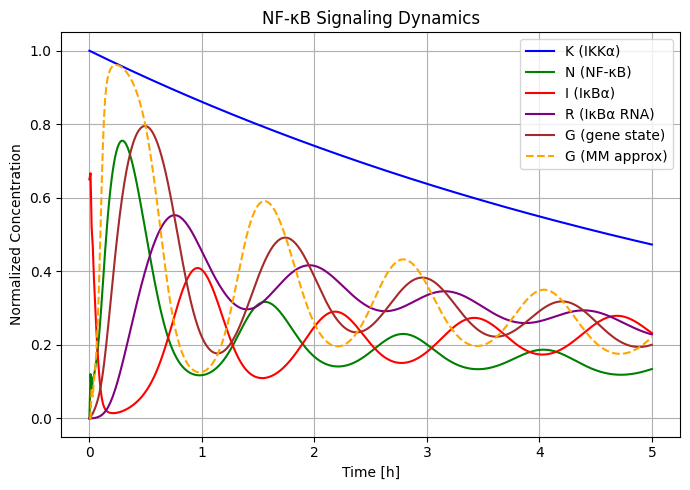

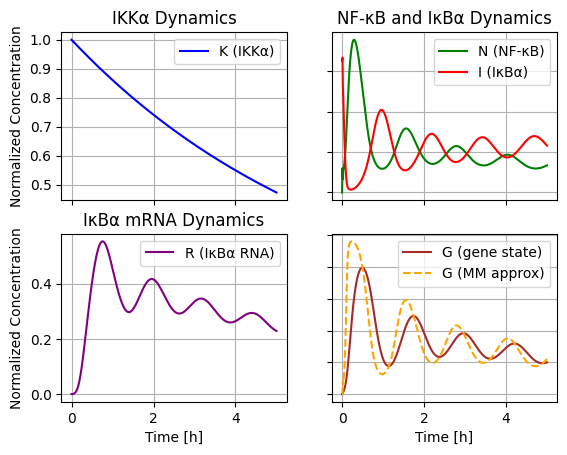

In [8]:
# POCIATOCNE hodnoty
K0, N0, I0, R0, G0 = 1.0, 0.0, 0.65, 0.0, 0.0

# SIMULACIA
simulator = Simulate_Basal_System(K0, N0, I0, R0, G0)
simulator.run()
t, K, N, I, R, G, G_mm = simulator.get_results()
plot_nfkb_dynamics(t, K, N, I, R, G, G_mm)


In [1]:
from simulacia import SimulateCompartmentalSystem
from vizualizacia import plot_compartmental_dynamics

ImportError: cannot import name 'CompartmentalParameters' from 'parametre' (c:\Users\sevco\Documents\modelovanie\New\Model_of_NF-kB_dynamics_in_the_cell\notebooks\parametre.py)

In [ ]:
simulator = SimulateCompartmentalSystem(t_max=10.0) # You can adjust t_max as needed
t, K, N_C, N_N, I_C, I_N, NI_C, NI_N, G, R = simulator.run()

plot_compartmental_dynamics(t, K, N_C, N_N, I_C, I_N, NI_C, NI_N, R, G)

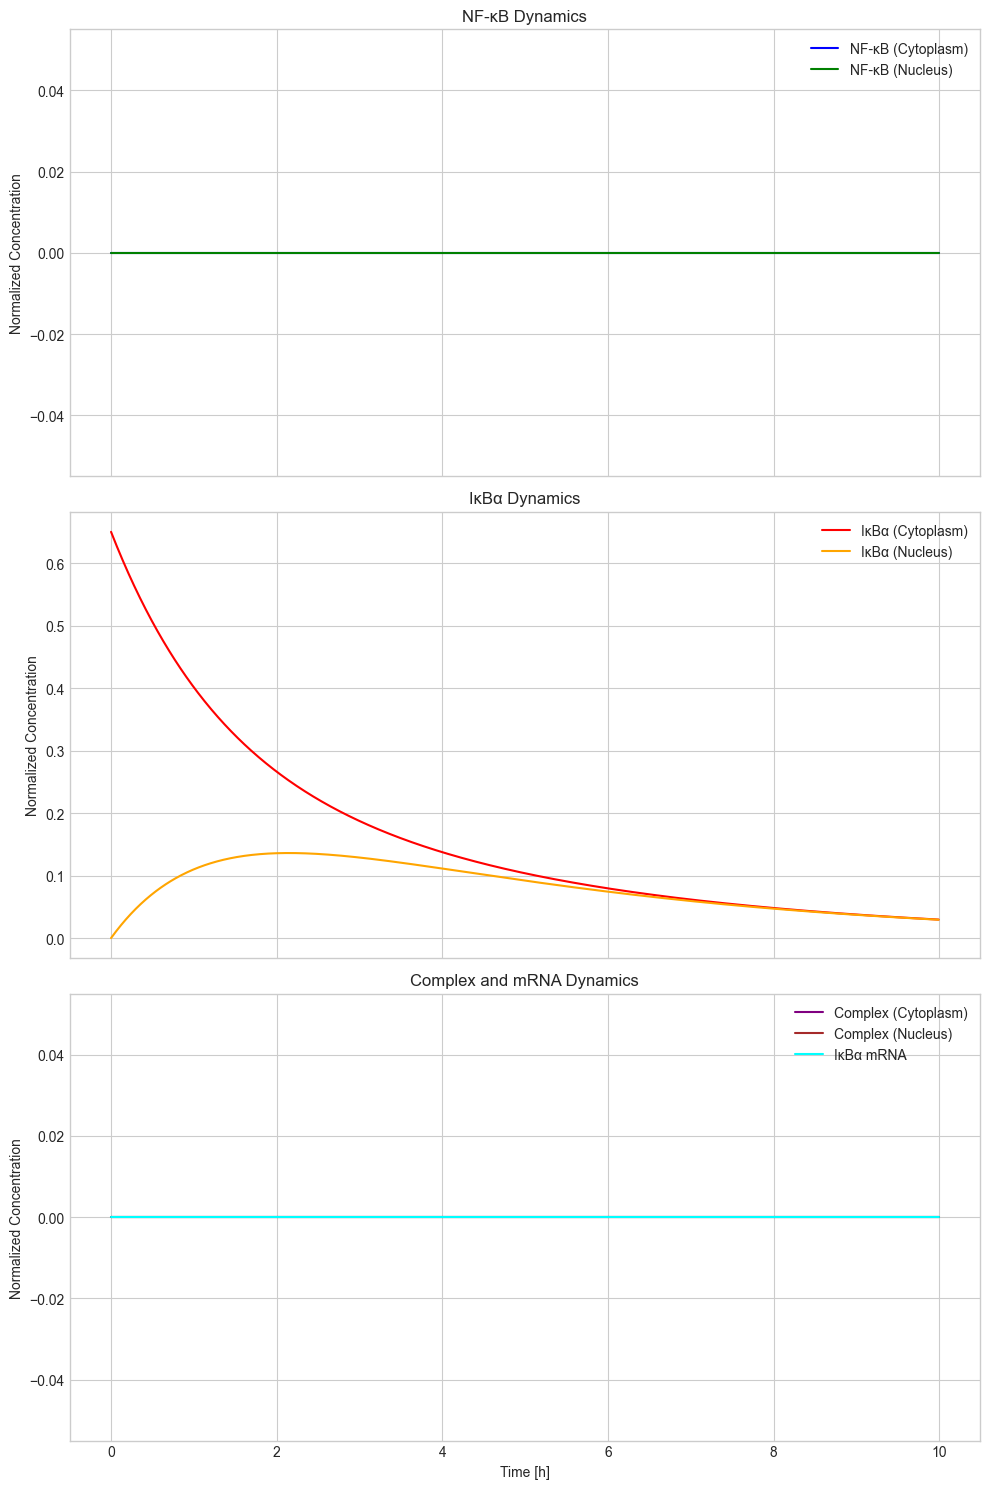

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# A single class to hold all parameters for clarity and easy modification.
class CompartmentalParameters:
    def __init__(self):
        # Basal system parameters
        self.d_K = 0.15      # IKKα degradation
        self.d = 3.0         # {NI} complex dissociation
        self.gamma = 0.2     # Spontaneous {NI} degradation
        self.d_I = 0.24      # Free IκBα spontaneous degradation
        self.p = 9.0         # IKKα-induced IκBα degradation factor
        self.k_A = 200.0     # Association of NF-κB and IκBα in cytoplasm
        self.k_A_N = 500.0   # Association of NF-κB and IκBα in nucleus
        self.kappa = 0.2     # IKKα-induced degradation scaling factor
        self.K_P = 16.0      # IκBα mRNA translation rate
        self.d_R = 2.7       # IκBα mRNA degradation
        self.k_ON = 7.5      # IκBα gene activation by nuclear NF-κB
        self.k_OFF = 15.0    # IκBα gene inactivation by nuclear IκBα

        # New compartmentalization parameters
        self.k_imp_N = 0.1   # Free NF-κB import to nucleus
        self.k_exp_NI = 0.2  # {NI} complex export from nucleus
        self.k_imp_I = 0.28  # Free IκBα import to nucleus
        self.k_exp_I = 0.28  # Free IκBα export from nucleus

# A single class to define the differential equations for the compartmentalized system.
class CompartmentalSystem:
    def __init__(self, params=None):
        self.parameters = params if params else CompartmentalParameters()

    def d_eqs(self, t, y):
        """
        Defines the system of ordinary differential equations (ODEs).
        y is a vector of concentrations: [K, N_C, N_N, I_C, I_N, NI_C, NI_N, G, R]
        """
        K, N_C, N_N, I_C, I_N, NI_C, NI_N, G, R = y
        p = self.parameters

        # dK/dt
        dK_dt = -p.d_K * K

        # Rule: Free NF-κB is actively transported into the nucleus
        # Rule: Free NF-κB is not transported out of the nucleus
        dN_C_dt = p.k_exp_NI * NI_N + p.d * NI_C + p.p * K * NI_C - p.k_imp_N * N_C - p.k_A * N_C * I_C
        dN_N_dt = p.k_imp_N * N_C - p.k_A_N * N_N * I_N

        # Rule: IκB mRNA is translated to form IκB protein in the cytoplasm
        # Rule: IκB protein can be transported in and out of the nucleus
        dI_C_dt = p.K_P * R - p.k_A * N_C * I_C - p.k_imp_I * I_C + p.k_exp_I * I_N - p.d_I * I_C + p.p * K * NI_C + p.gamma * NI_C
        dI_N_dt = -p.k_A_N * N_N * I_N + p.k_imp_I * I_C - p.k_exp_I * I_N - p.d_I * I_N

        # Rule: In both compartments, IκB forms a complex with NF-κB
        # Rule: {NI} complex cannot be imported into the nucleus
        # Rule: {NI} complex can be exported out of the nucleus
        dNI_C_dt = p.k_A * N_C * I_C - p.d * NI_C - p.p * K * NI_C - p.gamma * NI_C - p.k_exp_NI * NI_N
        dNI_N_dt = p.k_A_N * N_N * I_N - p.k_exp_NI * NI_N

        # Rule: NF-κB in the nucleus activates transcription of the IκBα gene
        # The transcription rate is dependent on N_N.
        dG_dt = p.k_ON * N_N * (1 - G) - p.k_OFF * I_N * G
        dR_dt = p.d_R * (G - R)

        return [dK_dt, dN_C_dt, dN_N_dt, dI_C_dt, dI_N_dt, dNI_C_dt, dNI_N_dt, dG_dt, dR_dt]

# A single class to handle the simulation loop and data storage.
class SimulateCompartmentalSystem:
    def __init__(self, K0=1.0, N_C0=0.0, N_N0=0.0, I_C0=0.65, I_N0=0.0, NI_C0=0.0, NI_N0=0.0, G0=0.0, R0=0.0, dt=0.01, t_max=5.0):
        self.K0 = K0
        self.N_C0 = N_C0
        self.N_N0 = N_N0
        self.I_C0 = I_C0
        self.I_N0 = I_N0
        self.NI_C0 = NI_C0
        self.NI_N0 = NI_N0
        self.G0 = G0
        self.R0 = R0
        self.dt = dt
        self.t_max = t_max

        self.system = CompartmentalSystem()
        self.params = self.system.parameters
        self.n_steps = int(t_max / dt)

        self.t = np.zeros(self.n_steps)
        self.K = np.zeros(self.n_steps)
        self.N_C = np.zeros(self.n_steps)
        self.N_N = np.zeros(self.n_steps)
        self.I_C = np.zeros(self.n_steps)
        self.I_N = np.zeros(self.n_steps)
        self.NI_C = np.zeros(self.n_steps)
        self.NI_N = np.zeros(self.n_steps)
        self.G = np.zeros(self.n_steps)
        self.R = np.zeros(self.n_steps)

    def run(self):
        # Initial values
        self.K[0] = self.K0
        self.N_C[0] = self.N_C0
        self.N_N[0] = self.N_N0
        self.I_C[0] = self.I_C0
        self.I_N[0] = self.I_N0
        self.NI_C[0] = self.NI_C0
        self.NI_N[0] = self.NI_N0
        self.G[0] = self.G0
        self.R[0] = self.R0

        # Simulation loop using Euler method
        for i in range(1, self.n_steps):
            self.t[i] = self.t[i-1] + self.dt

            y_prev = [self.K[i-1], self.N_C[i-1], self.N_N[i-1], self.I_C[i-1], self.I_N[i-1], self.NI_C[i-1], self.NI_N[i-1], self.G[i-1], self.R[i-1]]
            dK, dN_C, dN_N, dI_C, dI_N, dNI_C, dNI_N, dG, dR = self.system.d_eqs(self.t[i-1], y_prev)

            self.K[i] = self.K[i-1] + dK * self.dt
            self.N_C[i] = self.N_C[i-1] + dN_C * self.dt
            self.N_N[i] = self.N_N[i-1] + dN_N * self.dt
            self.I_C[i] = self.I_C[i-1] + dI_C * self.dt
            self.I_N[i] = self.I_N[i-1] + dI_N * self.dt
            self.NI_C[i] = self.NI_C[i-1] + dNI_C * self.dt
            self.NI_N[i] = self.NI_N[i-1] + dNI_N * self.dt
            self.G[i] = self.G[i-1] + dG * self.dt
            self.R[i] = self.R[i-1] + dR * self.dt

        return self.t, self.K, self.N_C, self.N_N, self.I_C, self.I_N, self.NI_C, self.NI_N, self.G, self.R

# A single function to visualize the simulation results.
def plot_compartmental_dynamics(t, K, N_C, N_N, I_C, I_N, NI_C, NI_N, R, G):
    """
    Plots the dynamics of the compartmentalized NF-κB system.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

    # Plot NF-κB dynamics
    axs[0].plot(t, N_C, label='NF-κB (Cytoplasm)', color='blue')
    axs[0].plot(t, N_N, label='NF-κB (Nucleus)', color='green')
    axs[0].set_title('NF-κB Dynamics')
    axs[0].set_ylabel('Normalized Concentration')
    axs[0].legend()

    # Plot IκB dynamics
    axs[1].plot(t, I_C, label='IκBα (Cytoplasm)', color='red')
    axs[1].plot(t, I_N, label='IκBα (Nucleus)', color='orange')
    axs[1].set_title('IκBα Dynamics')
    axs[1].set_ylabel('Normalized Concentration')
    axs[1].legend()

    # Plot Complex and mRNA dynamics
    axs[2].plot(t, NI_C, label='Complex (Cytoplasm)', color='purple')
    axs[2].plot(t, NI_N, label='Complex (Nucleus)', color='brown')
    axs[2].plot(t, R, label='IκBα mRNA', color='cyan')
    axs[2].set_title('Complex and mRNA Dynamics')
    axs[2].set_xlabel('Time [h]')
    axs[2].set_ylabel('Normalized Concentration')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

# Main execution block
if __name__ == '__main__':
    simulator = SimulateCompartmentalSystem(t_max=10.0) # You can adjust t_max as needed
    t, K, N_C, N_N, I_C, I_N, NI_C, NI_N, G, R = simulator.run()

    plot_compartmental_dynamics(t, K, N_C, N_N, I_C, I_N, NI_C, NI_N, R, G)

In [8]:
from simulacia import SimulateCompartmentalSystem
from vizualizacia import plot_compartmental_dynamics

ImportError: cannot import name 'CompartmentalParameters' from 'parametre' (c:\Users\sevco\Documents\modelovanie\New\Model_of_NF-kB_dynamics_in_the_cell\notebooks\parametre.py)

In [ ]:
simulator = SimulateCompartmentalSystem(t_max=10.0) # You can adjust t_max as needed
t, K, N_C, N_N, I_C, I_N, NI_C, NI_N, G, R = simulator.run()
plot_compartmental_dynamics(t, K, N_C, N_N, I_C, I_N, NI_C, NI_N, R, G)